In [1]:
# External dependencies

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv, gamma
from scipy.spatial.distance import cdist
from scipy.linalg import cholesky, cho_solve

# https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

In [3]:
# INPUT DATA

# Sample points for prediction
X = np.linspace(-10, 10, 100).reshape(-1, 1)  # 100 points from -5 to 5

# Observed data points
X_train = np.linspace(-10, 10, 11).reshape(-1, 1)  # 10 training points
#y_train = np.sin(X_train).flatten()  # Example function values at training points
y_train = -np.square(X_train).flatten()  # Example function values at training points

y_train[1] = -100
y_train[2] = -80
y_train[3] = -50
y_train[7] = -40
y_train[8] = -90
y_train[9] = -100

y_train = y_train * 10

# Sample points for prediction
X = np.linspace(-1000, 1000, 100).reshape(-1, 1)  # 100 points from -5 to 5
# Observed data points
X_train = np.linspace(-1000, 1000, 11).reshape(-1, 1)  # 10 training points


In [4]:
# KERNELS

# RBF kernel function
def rbf_kernel(x1, x2, length_scale, variance):
    sqdist = np.sum((x1 - x2)**2)
    return variance * np.exp(-0.5 * sqdist / length_scale**2)

# Matern kernel function
def matern_kernel(x1, x2, length_scale, nu, variance):
    
    # Calculate the Euclidean distance between points
    d = np.sqrt(np.sum((x1 - x2)**2, axis=-1))
    
    # Special case where nu is large (approximates RBF kernel)
    if nu == np.inf:
        return variance * np.exp(-0.5 * (d / length_scale)**2)
    
    # Compute the Matern kernel
    scaling_factor = 2**(1.0 - nu) / gamma(nu)
    distance_term = np.sqrt(2 * nu) * d / length_scale
    matern_value = scaling_factor * (distance_term**nu) * kv(nu, distance_term)
        
    # Handle the case when distance is zero to avoid NaNs
    matern_value = np.where(d == 0.0, 1, matern_value)
    #matern_value = np.nan_to_num(matern_value, variance)
    
    return variance * matern_value

# Variogram model (spherical)
def variogram(h, range_a, sill, nugget):
    """ Spherical variogram model """
    h = np.abs(h)
    return np.where(h < range_a,
                    nugget + sill * (1.5 * (h / range_a) - 0.5 * (h / range_a)**3),
                    nugget + sill)

In [5]:
# PARAMETERS FOR COVARIANCE MATRIX AND VARIOGRAM

# Noise
noise = 10

# Covariance matrix parameters
length_scale = 500
variance = 500
varaiance_for_title = variance
nu = 1.5 # 1/2 becomes exponential covariance function k(r) = exp(-r/l)
         # 3/2 and 5/2 for ML
         # Carl Edward Rasmussen and Christopher K. I. Williams,
         # Gaussian Processes for Machine Learning,
         # Adaptive Computation and Machine Learning (Cambridge, Mass: MIT Press, 2006), p85.

# Variogram parameters
range_a = length_scale  # Range of the variogram, assumed equal to length scale of covariance matrix kernel
sill = variance  # Sill of the variogram, , assumed equal to variance of covariance matrix kernel
nugget = noise # Nugget effect



In [5]:
# WHITE NOISE GENERATION

WhiteKernel(noise_level=1, noise_level_bounds=(1e-5, 1e1))

WhiteKernel(noise_level=1)

In [6]:
# GAUSSIAN PROCESS EXAMPLE 

# Covariance matrix for the training points
K = np.zeros((len(X_train), len(X_train)))
for i in range(len(X_train)):
    for j in range(len(X_train)):
        K[i, j] = matern_kernel(X_train[i], X_train[j], length_scale, nu, variance)

# Add noise to diagonal of covariance matrix
K = K + np.random.normal(0, noise, len(X_train)) * np.eye(len(X_train))

# Covariance matrix between the training points and the test points
K_s = np.zeros((len(X_train), len(X)))
for i in range(len(X_train)):
    for j in range(len(X)):
        K_s[i, j] = matern_kernel(X_train[i], X[j], length_scale, nu, variance)

# Covariance matrix for the test points
K_ss = np.zeros((len(X), len(X)))
for i in range(len(X)):
    for j in range(len(X)):
        K_ss[i, j] = matern_kernel(X[i], X[j], length_scale, nu, variance)

# Mean and covariance of the conditional distribution
K_inv = np.linalg.inv(K + 1e-8 * np.eye(len(X_train)))  # Add a small noise term for numerical stability

# Mean of the conditioned GP
mu_s = K_s.T.dot(K_inv).dot(y_train)

# Covariance of the conditioned GP
cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)

# Samples from the conditioned GP
np.random.seed(42)
samples = np.random.multivariate_normal(mu_s, cov_s, 3)  # 3 samples

C:\Users\cco\AppData\Local\Temp\ipykernel_24720\2422404920.py:21: RuntimeWarning: invalid value encountered in double_scalars
  matern_value = scaling_factor * (distance_term**nu) * kv(nu, distance_term)
C:\Users\cco\AppData\Local\Temp\ipykernel_24720\1232374528.py:35: RuntimeWarning: covariance is not positive-semidefinite.
  samples = np.random.multivariate_normal(mu_s, cov_s, 3)  # 3 samples


In [7]:
# SEQUENTIAL GAUSSIAN SIMULATION WITH COVARIANCE MATRIX

# Function to perform SGS
def sequential_gaussian_simulation(X_train, y_train, X, kernel, length_scale, variance, num_simulations):
    simulations = np.zeros((num_simulations, len(X)))
    for s in range(num_simulations):
        y_sim = np.zeros(len(X))
        for i, xi in enumerate(X):
            X_all = np.vstack([X_train, X[:i+1]])
            K = np.zeros((len(X_all), len(X_all)))
            for m in range(len(X_all)):
                for n in range(len(X_all)):
                    K[m, n] = kernel(X_all[m], X_all[n], length_scale, variance)
            
            K_train = K[:len(X_train) + i, :len(X_train) + i]
            K_train_inv = np.linalg.inv(K_train + 1e-8 * np.eye(len(K_train)))
            
            K_s = K[:len(X_train) + i, len(X_train) + i:len(X_train) + i + 1]
            K_s = np.round_(K_s, 8)
            K_ss = K[len(X_train) + i:len(X_train) + i + 1, len(X_train) + i:len(X_train) + i + 1]
            
            mu = K_s.T.dot(K_train_inv).dot(np.append(y_train, y_sim[:i]))
            sigma = np.max((K_ss - K_s.T.dot(K_train_inv).dot(K_s), 0))
            #sigma = np.abs(K_ss - K_s.T.dot(K_train_inv).dot(K_s))
            y_sim[i] = np.random.normal(mu, np.sqrt(sigma))
            
        simulations[s, :] = y_sim
    return simulations

# Perform SGS
num_simulations = 5
simulations = sequential_gaussian_simulation(X_train, y_train, X, rbf_kernel, length_scale, variance, num_simulations)


d:\Apps\Anaconda3\envs\gempy3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [8]:
# SEQUENTIAL GAUSSIAN SIMULATION WITH VARIOGRAM

nx = len(X)

# Perform SGS with conditioning data
num_simulations = 3
simulations = np.zeros((num_simulations, nx))

for s in range(num_simulations):
    y_sim = np.zeros(nx)
    for i in range(nx):
        X_all = np.vstack([X_train, X[:i+1]])
        
        # Calculate the covariance matrix using the variogram
        h = cdist(X_all, X_all)
        cov_matrix = sill - variogram(h, range_a, sill, nugget)
        
        # Split the covariance matrix
        cov_11 = cov_matrix[:len(X_train)+i, :len(X_train)+i]
        cov_12 = cov_matrix[:len(X_train)+i, len(X_train)+i:len(X_train)+i+1]
        cov_22 = cov_matrix[len(X_train)+i:len(X_train)+i+1, len(X_train)+i:len(X_train)+i+1]
        
        # Calculate the mean and variance for the new point
        mean = cov_12.T @ np.linalg.pinv(cov_11) @ np.hstack([y_train, y_sim[:i]])
        variance = cov_22 - cov_12.T @ np.linalg.pinv(cov_11) @ cov_12
        
        # Draw a random sample from the normal distribution
        y_sim[i] = np.random.normal(mean, np.sqrt(variance))
    
    simulations[s, :] = y_sim

C:\Users\cco\AppData\Local\Temp\ipykernel_24720\1803430317.py:28: RuntimeWarning: invalid value encountered in sqrt
  y_sim[i] = np.random.normal(mean, np.sqrt(variance))


C:\Users\cco\AppData\Local\Temp\ipykernel_24720\3163751119.py:11: RuntimeWarning: invalid value encountered in sqrt
  plt.fill_between(X.flatten(), mu_s - 1.96 * np.sqrt(np.diag(cov_s)), mu_s + 1.96 * np.sqrt(np.diag(cov_s)), color='gray', alpha=0.2, label='95% Conf. Int.')


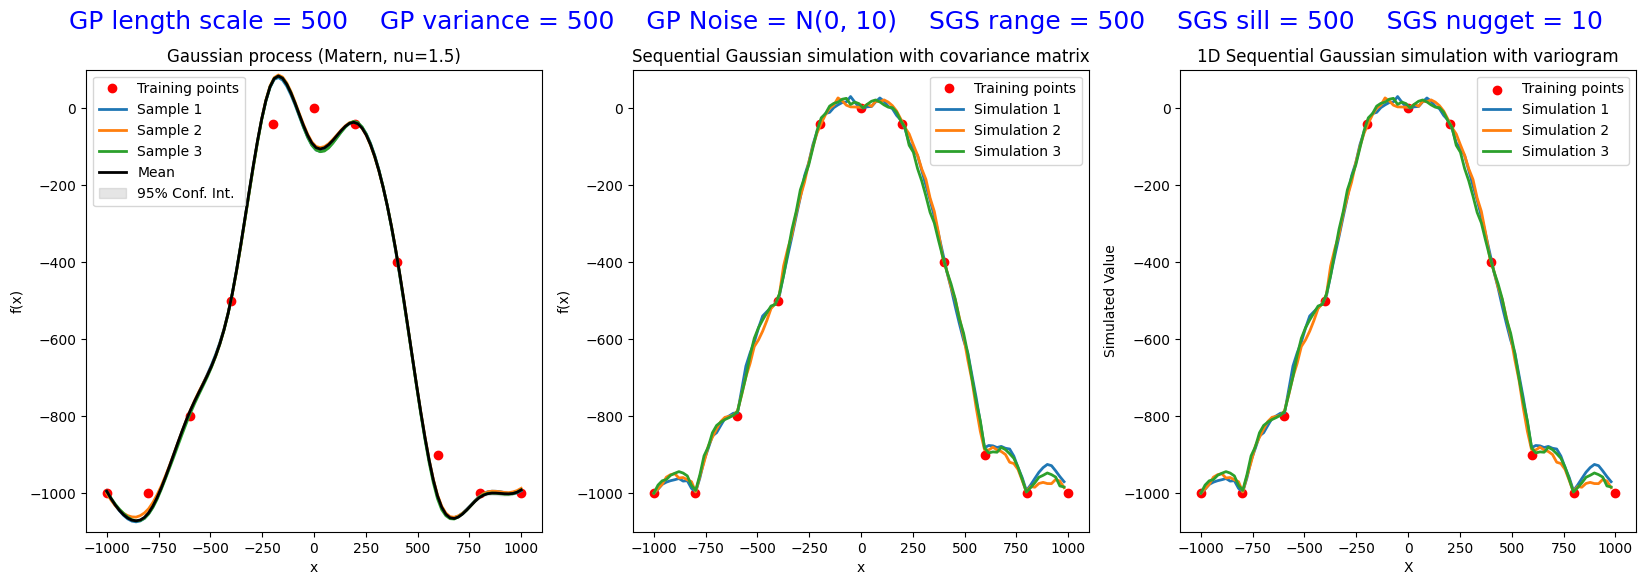

In [9]:
# PLOT GP AND SGSs COMPARISON

plt.figure(figsize=(20, 6))
plt.suptitle(f"GP length scale = {length_scale}    GP variance = {varaiance_for_title}    GP Noise = N(0, {noise})    SGS range = {range_a}    SGS sill = {sill}    SGS nugget = {noise}", fontsize=18, color="blue")

plt.subplot(1, 3, 1)
plt.plot(X_train, y_train, 'ro', label='Training points')
for i in range(3):
    plt.plot(X, samples[i], label=f'Sample {i+1}', lw=2)
plt.plot(X, mu_s, 'k', lw=2, label='Mean')
plt.fill_between(X.flatten(), mu_s - 1.96 * np.sqrt(np.diag(cov_s)), mu_s + 1.96 * np.sqrt(np.diag(cov_s)), color='gray', alpha=0.2, label='95% Conf. Int.')
plt.title('Gaussian process (Matern, nu=1.5)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim((-1100, 100))
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(X_train, y_train, 'ro', label='Training points')
for i in range(num_simulations):
    plt.plot(X, simulations[i], label=f'Simulation {i+1}', lw=2)
plt.title('Sequential Gaussian simulation with covariance matrix')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.ylim((-1100, 100))
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(X_train, y_train, c='red', label='Training points')
for i in range(num_simulations):
    plt.plot(X, simulations[i], label=f'Simulation {i+1}', lw=2)
plt.title('1D Sequential Gaussian simulation with variogram')
plt.xlabel('X')
plt.ylabel('Simulated Value')
plt.legend()
#plt.grid(True)
plt.ylim((-1100, 100))

plt.show()


### https://pylops.readthedocs.io/en/stable/tutorials/solvers.html

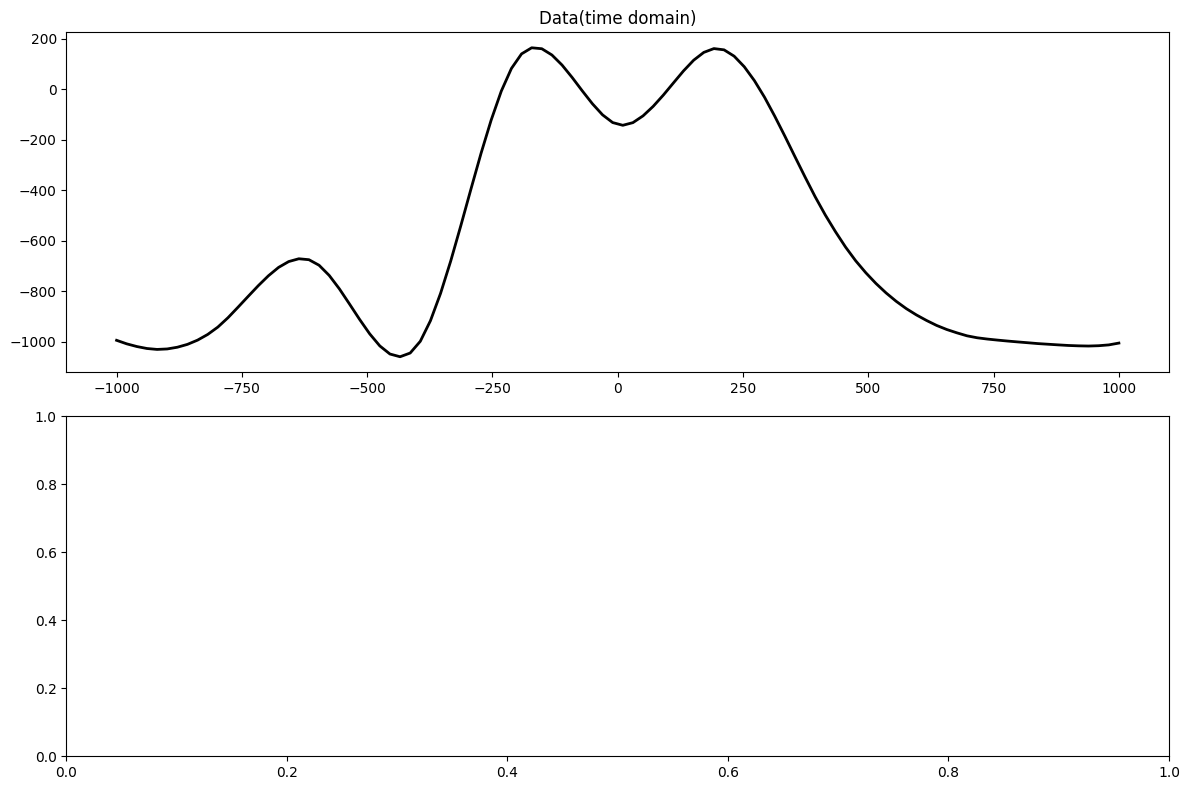

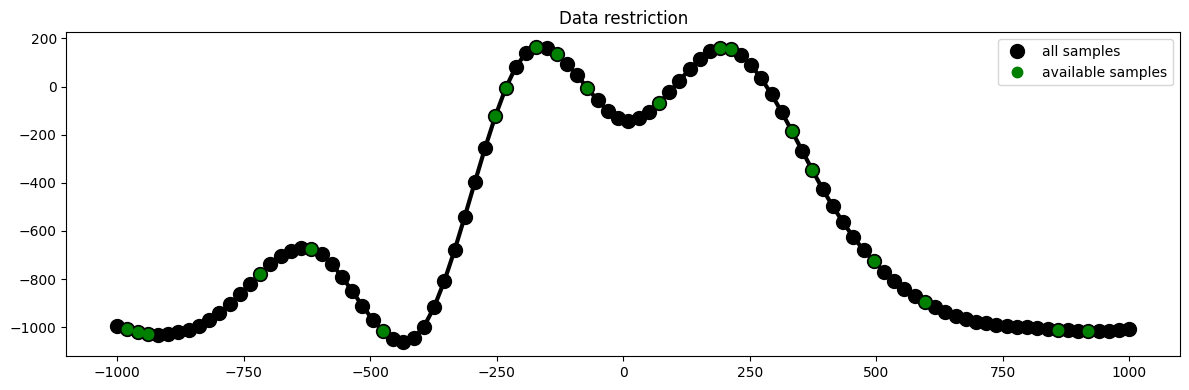

In [10]:
import pylops

plt.close("all")
np.random.seed(10)

t= X
x = samples[2]
N = len(t)

fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(t, x, "k", lw=2)
axs[0].set_title("Data(time domain)")
axs[0].axis("tight")
plt.tight_layout()

# subsampling locations
perc_subsampling = 0.2
Nsub = int(np.round(N * perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(N))[:Nsub])

# Create restriction operator
Rop = pylops.Restriction(N, iava, dtype="float64")

y = Rop * x
ymask = Rop.mask(x)

# Visualize data
fig = plt.figure(figsize=(12, 4))
plt.plot(t, x, "k", lw=3)
plt.plot(t, x, ".k", ms=20, label="all samples")
plt.plot(t, ymask, ".g", ms=15, label="available samples")
plt.legend()
plt.title("Data restriction")
plt.tight_layout()

In [11]:
# Create regularization operator
D2op = pylops.SecondDerivative(N, dtype="float64")

# Regularized inversion
epsR = np.sqrt(0.1)
epsI = np.sqrt(1e-4)

xne = pylops.optimization.leastsquares.normal_equations_inversion(
    Rop, y, [D2op], epsI=epsI, epsRs=[epsR], **dict(maxiter=50)
)[0]

In [12]:
ND2op = pylops.MatrixMult((D2op.H * D2op).tosparse())  # mimic fast D^T D

xne1 = pylops.optimization.leastsquares.normal_equations_inversion(
    Rop, y, [], NRegs=[ND2op], epsI=epsI, epsNRs=[epsR], **dict(maxiter=50)
)[0]

In [13]:
xreg = pylops.optimization.leastsquares.regularized_inversion(
    Rop,
    y,
    [D2op],
    epsRs=[np.sqrt(0.1)],
    **dict(damp=np.sqrt(1e-4), iter_lim=50, show=0)
)[0]

In [14]:
# Create regularization operator
Sop = pylops.Smoothing1D(nsmooth=11, dims=[N], dtype="float64")

# Invert for interpolated signal
xprec = pylops.optimization.leastsquares.preconditioned_inversion(
    Rop, y, Sop, **dict(damp=np.sqrt(1e-9), iter_lim=20, show=0)
)[0]

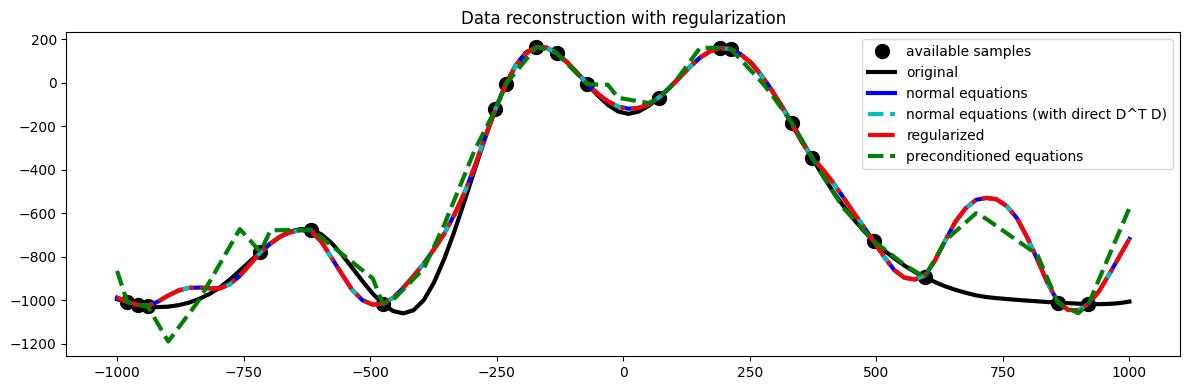

In [15]:
# sphinx_gallery_thumbnail_number=4
fig = plt.figure(figsize=(12, 4))
plt.plot(t[iava], y, ".k", ms=20, label="available samples")
plt.plot(t, x, "k", lw=3, label="original")
plt.plot(t, xne, "b", lw=3, label="normal equations")
plt.plot(t, xne1, "--c", lw=3, label="normal equations (with direct D^T D)")
plt.plot(t, xreg, "-.r", lw=3, label="regularized")
plt.plot(t, xprec, "--g", lw=3, label="preconditioned equations")
plt.legend()
plt.title("Data reconstruction with regularization")

#subax = fig.add_axes([0.7, 0.2, 0.15, 0.6])
#subax.plot(t[iava], y, ".k", ms=20)
#subax.plot(t, x, "k", lw=3)
#subax.plot(t, xne, "b", lw=3)
#subax.plot(t, xne1, "--c", lw=3)
#subax.plot(t, xreg, "-.r", lw=3)
#subax.plot(t, xprec, "--g", lw=3)
#subax.set_xlim(0.05, 0.3)
plt.tight_layout()

### Gaussian Field

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Grid
x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 50)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T

# Kernel
length_scale = 1.0
variance = 1.0
kernel = variance * RBF(length_scale=length_scale)

# Generate the Gaussian field
gp = GaussianProcessRegressor(kernel=kernel, random_state=42)
Z = gp.sample_y(grid_points, 1).reshape(X.shape)

In [17]:
# Randomly select 3 points from the previous field
np.random.seed(42)
indices = np.random.choice(len(grid_points), 100, replace=False)
selected_points = grid_points[indices]
selected_values = Z.ravel()[indices]

#print("Selected Points:\n", selected_points)
#print("Selected Values:\n", selected_values)

In [18]:
# Train a Gaussian process with the previous extracted points
gp_small = GaussianProcessRegressor(kernel=kernel, random_state=42)
gp_small.fit(selected_points, selected_values)

# Predict the Gaussian field using the trained Gaussian process
Z_pred, Z_std = gp_small.predict(grid_points, return_std=True)
Z_pred = Z_pred.reshape(X.shape)

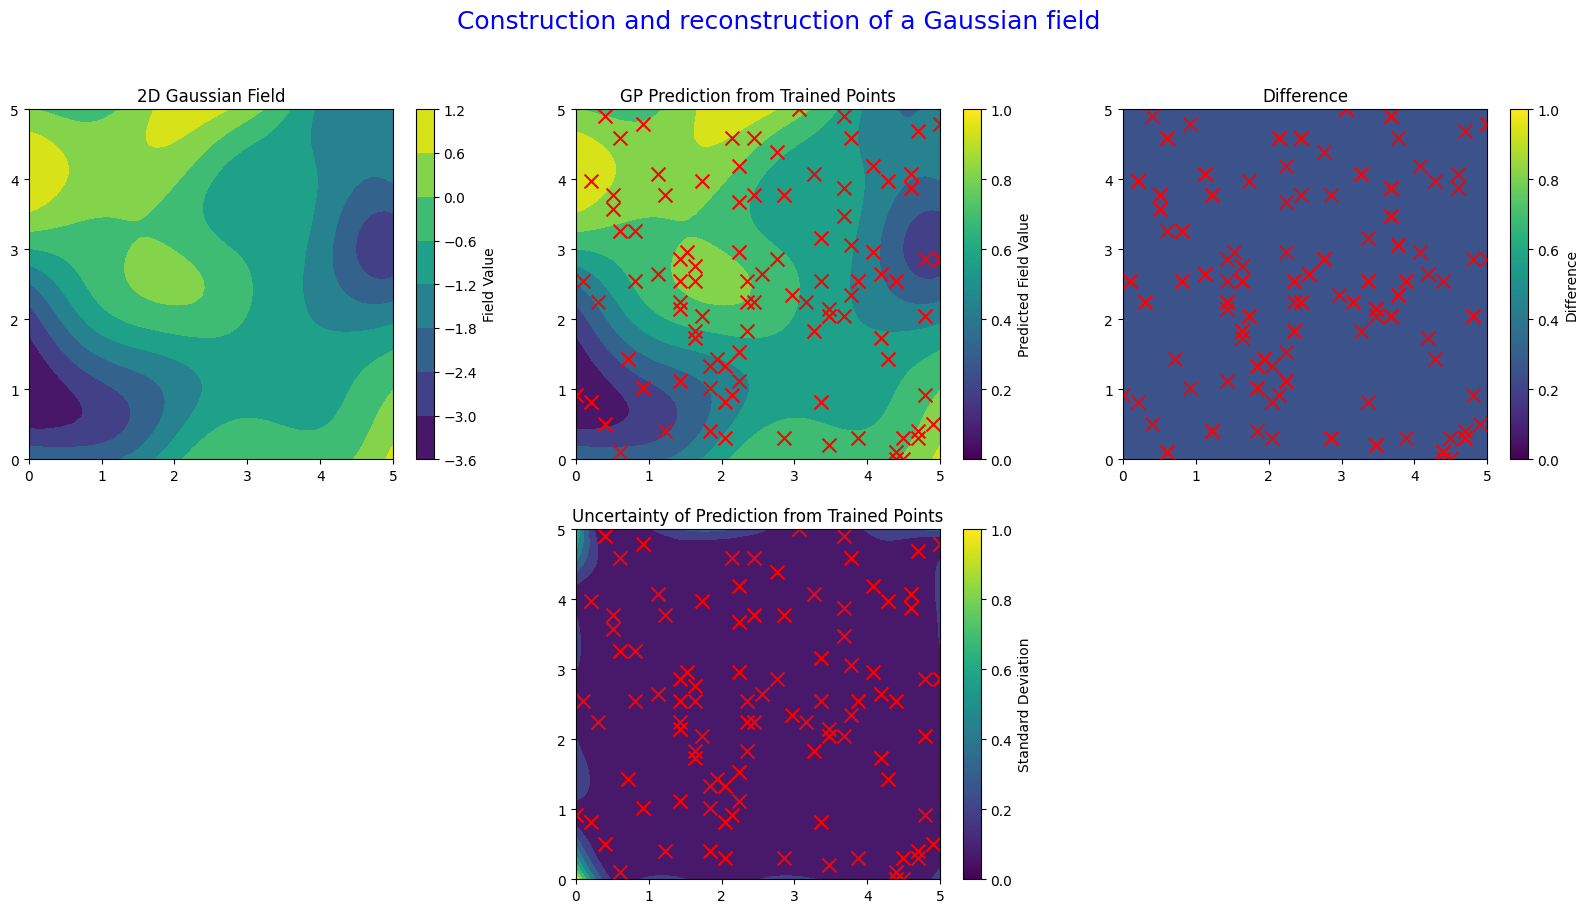

In [19]:
# Plot both original and reconstructed Gaussian fields

plt.figure(figsize=(20, 10))
plt.suptitle(f"Construction and reconstruction of a Gaussian field", fontsize=18, color="blue")

# Original Gaussian field
plt.subplot(2, 3, 1)
plt.contourf(X, Y, Z, cmap='viridis')
plt.title('2D Gaussian Field')
plt.colorbar(label='Field Value')
#plt.clim(-4,4)

# Predicted field
plt.subplot(2, 3, 2)
plt.contourf(X, Y, Z_pred, cmap='viridis')
plt.scatter(selected_points[:, 0], selected_points[:, 1], c='red', marker='x', s=100, label='Selected Points')
plt.title('GP Prediction from Trained Points')
plt.colorbar(label='Predicted Field Value')
#plt.clim(-4,4)

# Standard deviation of predicted field
plt.subplot(2, 3, 5)
plt.contourf(X, Y, Z_std.reshape(X.shape), cmap='viridis')
plt.scatter(selected_points[:, 0], selected_points[:, 1], c='red', marker='x', s=100, label='Selected Points')
plt.title('Uncertainty of Prediction from Trained Points')
plt.colorbar(label='Standard Deviation')

# Difference between original and predicted Gaussian fields
plt.subplot(2, 3, 3)
plt.contourf(X, Y, Z_pred - Z_pred, cmap='viridis')
plt.scatter(selected_points[:, 0], selected_points[:, 1], c='red', marker='x', s=100, label='Selected Points')
plt.title('Difference')
plt.colorbar(label='Difference')
#plt.clim(-4,4)

plt.show()

# Seismic

In [10]:
# External dependencies

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv, gamma
from scipy.spatial.distance import cdist
from scipy.linalg import cholesky, cho_solve

# https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

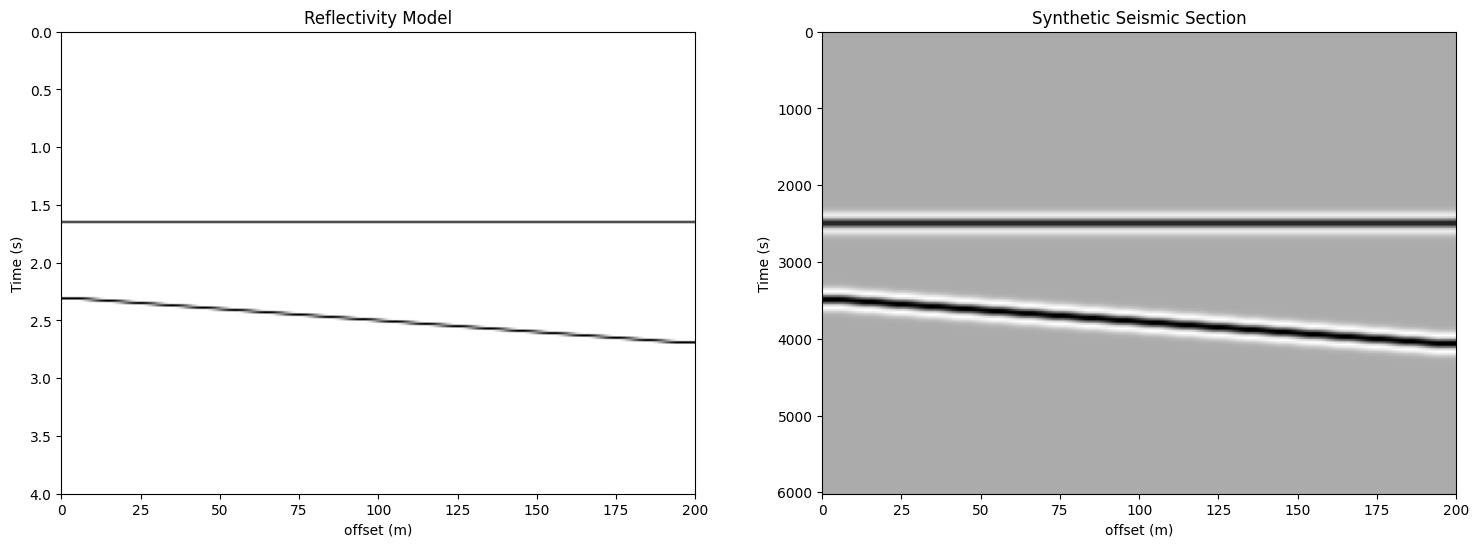

In [18]:
# SciPy Ricker wavelet
from scipy.signal import ricker

# Parameters
nt = 200    # Number of time samples
dt = 0.02   # Sampling interval (seconds)
nz = 20    # Number of traces
dx = 10     # Trace spacing (metres)

# Time and depth axis
time = np.arange(nt) * dt
offset = np.arange(nz) * dx

# Initialization of variable to save seismic sections (for serveral realizations)
n_realizations = 1
seismic_realizations=np.zeros((n_realizations, nt, nz))
seismic_realizations_depth=np.zeros((n_realizations, nt, nz))

# For loop for serveral realizations
for i in range(n_realizations):
    # Velocity model
    v = 1500 + np.random.normal(0, 150) # Velocity in m/s

    depth = time * v

    # Reflectivity model (2D grid with reflectors)
    reflectivity = np.zeros((nt, nz))

    # Horizontal reflector
    reflector_depth = int(2500 / (v * dt))
    reflectivity[reflector_depth, :] = 0.7  # Reflectivity coefficient

    # Dipping reflector
    slope = 1
    intercept_depth = int(3500 / (v * dt))
    for ix in range(nz):
        depth_idx = intercept_depth + int(ix * slope)
        if depth_idx < nt:  # Ensure we don't go out of bounds
            reflectivity[depth_idx, ix] = 0.9  # Reflectivity coefficient

    # Ricker wavelet from SciPy
    f0 = 10  # Dominant frequency (Hz)
    wavelet = ricker(nt/10, f0 * dt * 10)

    # Convolution of wavelet with reflectivity model to get each trace
    #seismic = np.apply_along_axis(lambda trace: np.convolve(trace, wavelet, mode='same'), axis=0, arr=reflectivity)
    seismic_list = []
    seismic_list_depth = []
    for j in range(reflectivity.shape[1]):
        trace = reflectivity[:, j]
        convolved_trace = np.convolve(trace, wavelet, mode='same')
        # Trace depth conversion
        convolved_trace_depth = convolved_trace * v
        seismic_list.append(convolved_trace)
        seismic_list_depth.append(convolved_trace_depth)

    seismic = np.array(seismic_list).T
    seismic_depth = np.array(seismic_list_depth).T

    # Noise
    noise = 0.0 * np.random.randn(nt, nz)

    # Saving of each seismic section in an array
    seismic_realizations[i] = seismic + noise
    seismic_realizations_depth[i] = seismic + noise


# Plots
plt.figure(figsize=(18, 6))

# Plot of Reflectivity Model
plt.subplot(1, 2, 1)
plt.imshow(reflectivity, cmap='gray_r', aspect='auto', extent=[0, nz * dx, nt * dt, 0])
plt.title('Reflectivity Model')
plt.xlabel('offset (m)')
plt.ylabel('Time (s)')

# Plot of Seismic Section
plt.subplot(1, 2, 2)
plt.imshow(np.sum(seismic_realizations_depth, axis=0), cmap='gray_r', aspect='auto', extent=[0, nz * dx, np.max(depth), 0]) # or nt * dt
plt.title('Synthetic Seismic Section')
plt.xlabel('offset (m)')
plt.ylabel('Depth (m)')
plt.show()



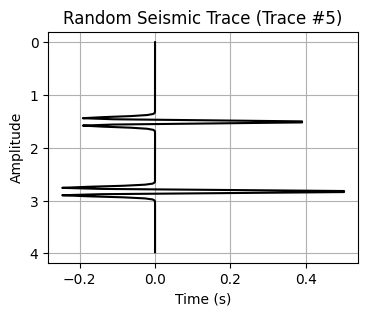

In [12]:
# Plot of a trace for QC

# Random trace index
random_trace_index = np.random.randint(0, nz)

# Selection of random trace
random_trace = seismic[:, random_trace_index]

# Plot of selected trace
plt.figure(figsize=(4, 3))
plt.plot(random_trace, time, color='black')
plt.gca().invert_yaxis()  # Invert y-axis to mimic seismic display
plt.title(f'Random Seismic Trace (Trace #{random_trace_index})')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

0.00044133360142686764
(4000, 4000)


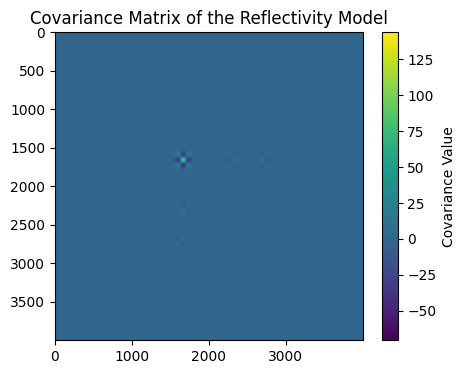

In [19]:
# SciPy required function
from scipy.spatial.distance import cdist

# Decimation
trace_decimation_rate = 1  # One trace every decimation_rate traces
tr_i_for_cov = np.arange(0, nz, trace_decimation_rate)  # Trace indexes for covariance matrix

# RBF kernel function
def rbf_kernel(x1, x2, length_scale, variance):
    """Radial Basis Function (RBF) kernel."""
    dists = cdist(x1, x2, 'euclidean')**2
    return variance * np.exp(-0.5 * dists / length_scale**2)

# Matern kernel function
def matern_kernel(x1, x2, length_scale, nu, variance):    
    # Calculate the Euclidean distance between points
    d = cdist(x1, x2, 'euclidean')
    # Special case where nu is large (approximates RBF kernel)
    if nu == np.inf:
        return variance * np.exp(-0.5 * (d / length_scale)**2)    
    # Computation of the Matern kernel
    scaling_factor = 2**(1.0 - nu) / gamma(nu)
    distance_term = np.sqrt(2 * nu) * d / length_scale
    matern_value = scaling_factor * (distance_term**nu) * kv(nu, distance_term)        
    # Handling of case when distance is zero, to avoid NaNs
    matern_value = np.where(d == 0.0, 1, matern_value)
    #matern_value = np.nan_to_num(matern_value, variance)    
    return variance * matern_value

# Definition of points where covariance is computed
coords_list = []
for t in depth:
    for x in offset[tr_i_for_cov]:
        coords_list.append((t, x))
coords = np.array(coords_list)

# Hyperparameters for the kernels
length_scale = 300  # Length scale (adjust as needed)
variance = 50.0  # Variance (adjust as needed)
nu = 1.5 # 1/2 becomes exponential covariance function k(r) = exp(-r/l)
         # 3/2 and 5/2 for ML
         # Carl Edward Rasmussen and Christopher K. I. Williams,
         # Gaussian Processes for Machine Learning,
         # Adaptive Computation and Machine Learning (Cambridge, Mass: MIT Press, 2006), p85.

# Covariance matrix computation
#cov_matrix = matern_kernel(coords, coords, length_scale, nu, variance)

mean = np.mean(seismic_depth[:,tr_i_for_cov].flatten())
centered_data = seismic_depth[:,tr_i_for_cov].flatten() - mean
cov_matrix = np.outer(centered_data, centered_data) / (len(seismic_depth[:,tr_i_for_cov].flatten()) - 1)

# Compute the covariance matrix
#cov_matrix = np.cov((reflectivity[:, tr_i_for_cov].flatten()+0.00000001).reshape((len(reflectivity[:, tr_i_for_cov].flatten()),1)), rowvar=True)

#mean = np.mean(reflectivity[:,tr_i_for_cov])
#cov_matrix = np.zeros((len(reflectivity[:,tr_i_for_cov]), len(tr_i_for_cov)))
#print(cov_matrix.shape)
#n = len(reflectivity[:,tr_i_for_cov]) * len(tr_i_for_cov)
#for i in range(len(reflectivity[:,tr_i_for_cov])):
#    jj = 0  # Use jj because j in tr_i_for_cov does not increase in steps of one
#    for j in tr_i_for_cov:
#        cov_matrix[i, jj] = (reflectivity[i,j] - mean) * (reflectivity[i,j] - mean) / (n - 1)
#        jj = jj + 1


#mean = np.mean(seismic_depth[:, tr_i_for_cov].flatten())
#n = len(seismic_depth[:, tr_i_for_cov].flatten())
#cov_matrix = np.zeros((n, n))
#print(cov_matrix.shape)
#for i in range (n):
#    for j in range (n):
#        cov_matrix[i, j] = (seismic_depth[:, tr_i_for_cov].flatten()[i] - mean)*(seismic_depth[:, tr_i_for_cov].flatten()[j]-mean) / (n-1)
#    print(f"Loop {i}")





print(mean)
print(cov_matrix.shape)

# Plot of covariance matrix
plt.figure(figsize=(5, 4))
plt.imshow(cov_matrix, cmap='viridis')
plt.colorbar(label='Covariance Value')
plt.title('Covariance Matrix of the Reflectivity Model')
#plt.clim(0, 0.0032)
plt.show()

In [23]:
from statistics import covariance
covariance(reflectivity[:, tr_i_for_cov].flatten(), reflectivity[:, tr_i_for_cov].flatten())

NameError: name 'tr_i_for_cov' is not defined

In [ ]:
#dist = cdist(coords, coords)
gamma = cov_matrix[0, 0] - cov_matrix
reflectivity.flatten().shape
dists.shape

(50000, 50000)

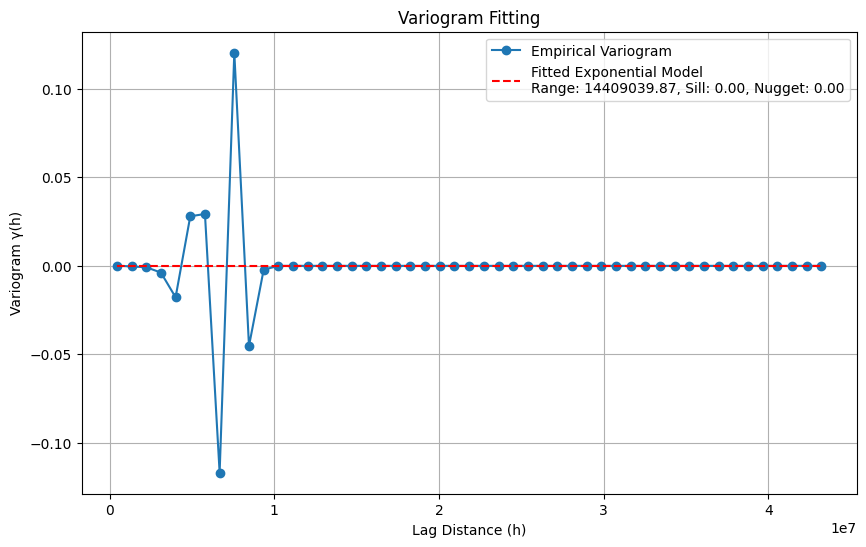

Optimal range of the variogram: 14409039.87
Optimal sill of the variogram: 0.00
Optimal nugget of the variogram: 0.00


In [75]:
# Required libraries from SciPy
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import curve_fit, minimize

# Computation of distance matrix between coordinates
#coords = np.array([(t, x) for t in range(int(nt/10)) for x in range(int(nz/10))]) # Manually divided by 10 to reduce the points
#dists = squareform(pdist(coords, 'euclidean'))
dists = cdist(coords, coords, 'euclidean')**2
#dists = np.zeros((len(coords),1))
#for i in range (len(coords)):
#    for j in range (len(coords)):
#        dists[i] = np.sqrt(np.sum((coords[i] - coords[j])**2, axis=-1))

# Computation of empirical variogram
#cov_matrix = np.exp(-dists / 10.0)  # synthetic covariance matrix # Assuming the covariance matrix is already computed (cov_matrix)
gamma = cov_matrix[0, 0] - cov_matrix

# Binning of offsets and computation of the average variogram for each bin
max_dist = np.max(dists)
bins = np.linspace(0, max_dist, 50)
bin_indices = np.digitize(dists, bins)

# Initialization of array for bin means
bin_means = []
bin_centers = []

for i in range(1, len(bins)):
    # Extraction of the gamma values corresponding to the current bin
    bin_gamma_values = gamma[bin_indices == i]
    if len(bin_gamma_values) > 0:
        bin_means.append(bin_gamma_values.mean())
        bin_centers.append((bins[i - 1] + bins[i]) / 2)

bin_means = np.array(bin_means)
bin_centers = np.array(bin_centers)


# Functions to fit a variogram model to the empirical variogram

def exponential_variogram(h, sill, range_, nugget):
    return nugget + sill * (1.0 - np.exp(-h / range_))

def spherical_variogram(h, sill, range_, nugget):
    return np.where(h <= range_, nugget + sill * (1.5 * (h / range_) - 0.5 * (h / range_)**3), nugget + sill)

def gaussian_variogram(h, sill, range_, nugget):
    return nugget + sill * (1 - np.exp(-(h**2) / (range_**2)))

# Define the loss function to minimize (Sum of Squared Errors)
def variogram_loss(params, h, gamma):
    sill, range_, nugget = params
    model_values = exponential_variogram(h, sill, range_, nugget)
    return np.sum((gamma - model_values) ** 2)  # Sum of squared errors


# Initialization of values for nugget, sill, and range
initial_sill = bin_means.max()
initial_range = np.max(bin_centers) / 3  # A third of the maximum distance to start
initial_nugget = bin_means.min()
#initial_nugget = 0
#initial_sill = 50#np.var(gamma)
#initial_range = 50

# Fitting of the variogram model
#popt, _ = curve_fit(gaussian_variogram, bin_centers, bin_means, p0=[initial_sill, initial_range, initial_nugget])
#sill_opt, range_opt, nugget_opt = popt

# Bounds for optimization: (lower bound, upper bound)
bounds = [(0, None), (0, None), (0, None)]  # Ensure non-negative values for sill, range, and nugget

# Minimization of the loss function with bounds
result = minimize(variogram_loss, [initial_sill, initial_range, initial_nugget], 
                  args=(bin_centers, bin_means), bounds=bounds)
sill_opt, range_opt, nugget_opt = result.x

# Computation of the fitted variogram model
fitted_variogram = gaussian_variogram(bin_centers, sill_opt, range_opt, nugget_opt)


# Plot of fitted variogram model with sill and nugget
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, bin_means, 'o-', label='Empirical Variogram')
#plt.plot(bin_centers, gaussian_variogram(bin_centers, sill_opt, range_opt, nugget_opt), 'r-', 
#         label=f'Fitted Exponential Model (Range={range_opt:.2f}, Sill={sill_opt:.2f}, Nugget={nugget_opt:.2f})')
plt.plot(bin_centers, fitted_variogram, 'r--', label=f'Fitted Exponential Model\nRange: {range_opt:.2f}, Sill: {sill_opt:.2f}, Nugget: {nugget_opt:.2f}')
plt.xlabel('Lag Distance (h)')
plt.ylabel('Variogram γ(h)')
plt.title('Variogram Fitting')
plt.legend()
plt.grid(True)
plt.show()

# Display of optimal range, sill, and nugget
print(f"Optimal range of the variogram: {range_opt:.2f}")
print(f"Optimal sill of the variogram: {sill_opt:.2f}")
print(f"Optimal nugget of the variogram: {nugget_opt:.2f}")

d:\Apps\Anaconda3\envs\gempy3\lib\site-packages\skgstat\plotting\variogram_plot.py:123: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


< spherical Semivariogram fitted to 10 bins >

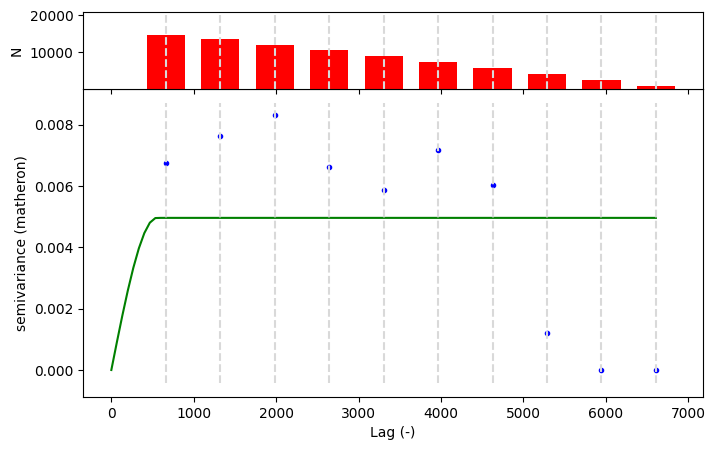

In [79]:
# QC with skgstat (SciKit gstat)

import skgstat as skg
V = skg.Variogram(coords[0::10], values[0::10])
V.plot()
V

In [53]:
V.parameters[0]

818.9270863613128

In [78]:
import numpy as np
from scipy.spatial.distance import pdist, squareform

def compute_variogram(coords, values, num_bins=50):
    # Compute pairwise distances between all coordinates
    dists = squareform(pdist(coords, 'euclidean'))
    
    # Compute the semi-variance (variogram)

    #gamma = 0.5 * squareform(pdist(values[:, np.newaxis], 'sqeuclidean'))

    # or with covariance matrix

    #mean_value = np.mean(values)
    #centered_values = values - mean_value
    #cov_matrix = np.cov(centered_values)
    variance = np.diag(cov_matrix)
    gamma = variance[:, np.newaxis] + variance[np.newaxis, :] - 2 * cov_matrix
    
    # Define bins for the distance values
    max_dist = np.max(dists)
    bins = np.linspace(0, max_dist, num_bins)
    
    # Bin the distances and compute the mean semi-variance for each bin
    bin_indices = np.digitize(dists, bins)
    
    bin_means = []
    bin_centers = []
    
    for i in range(1, len(bins)):
        bin_mask = (bin_indices == i)
        bin_gamma_values = gamma[bin_mask]
        if len(bin_gamma_values) > 0:
            bin_means.append(bin_gamma_values.mean())
            bin_centers.append((bins[i - 1] + bins[i]) / 2)
    
    return np.array(bin_centers), np.array(bin_means)

# Example Usage:
# Assuming you have coordinates and corresponding values
# coords = np.array([[x1, y1], [x2, y2], ...])
# values = np.array([v1, v2, ...])

#coords = np.array([[0, 0], [1, 1], [2, 2], [3, 3]])  # Example coordinates
#values = np.array([0.1, 0.4, 0.3, 0.7])  # Example values

values = reflectivity.flatten()

bin_centers, bin_means = compute_variogram(coords[0::10], values[0::10])

# Plotting the variogram

plt.figure(figsize=(10, 6))
plt.plot(bin_centers, bin_means, 'o-', label='Empirical Variogram')
plt.xlabel('Lag Distance (h)')
plt.ylabel('Variogram γ(h)')
plt.title('Empirical Variogram')
plt.legend()
plt.grid(True)
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 4000 but corresponding boolean dimension is 400

In [ ]:
del cov_matrix

(500, 10)

In [ ]:
range_opt = V.parameters[0]
sill_opt = V.parameters[1]
nugget_opt = V.parameters[2]

In [80]:
def exponential_variogram(h, sill, range_, nugget):
    return nugget + sill * (1.0 - np.exp(-h / range_))

def spherical_variogram(h, sill, range_, nugget):
    return np.where(h <= range_, nugget + sill * (1.5 * (h / range_) - 0.5 * (h / range_)**3), nugget + sill)

def gaussian_variogram(h, sill, range_, nugget):
    return nugget + sill * (1 - np.exp(-(h**2) / (range_**2)))

# Define the loss function to minimize (Sum of Squared Errors)
def variogram_loss(params, h, gamma):
    sill, range_, nugget = params
    model_values = exponential_variogram(h, sill, range_, nugget)
    return np.sum((gamma - model_values) ** 2)  # Sum of squared errors

In [ ]:
cov_matrix.shape

(203, 203)

C:\Users\cco\AppData\Local\Temp\ipykernel_24720\3010934212.py:46: RuntimeWarning: invalid value encountered in sqrt
  y_sim[i] = np.random.normal(mean, np.sqrt(variance))


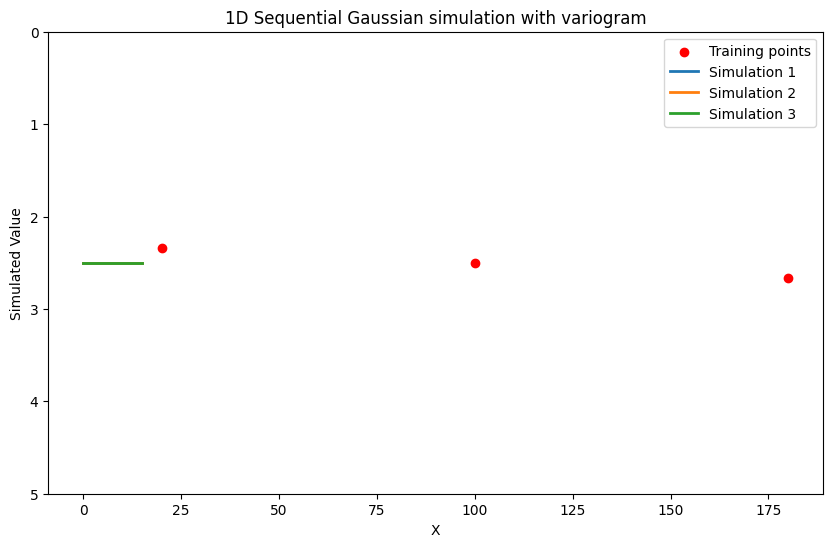

In [24]:
# Display of optimal range, sill, and nugget
#print(f"Optimal range of the variogram: {range_opt:.2f}")
#print(f"Optimal sill of the variogram: {sill_opt:.2f}")
#print(f"Optimal nugget of the variogram: {nugget_opt:.2f}")

# Input Data

# Sample points for prediction
X = offset.reshape(-1, 1) 
X = np.linspace(0, 1000, 200).reshape(-1, 1)
# Observed data points
X_train = np.array([[2 * dx,
                     10 * dx,
                     18 * dx]]).reshape(-1, 1)  # X of Training points
y_train = np.array([[seismic[:, 2].argmax() * dt,
                     seismic[:, 10].argmax() * dt,
                     seismic[:, 18].argmax() * dt]]).flatten()  # Y of Training points

nx = len(X)
nugget_opt = 0

# SGS with conditioning data
num_simulations = 3
simulations = np.zeros((num_simulations, nx))

for s in range(num_simulations):
    y_sim = np.zeros(nx)
    for i in range(nx):
        X_all = np.vstack([X_train, X[:i+1]])
        
        # Calculation of the covariance matrix using the variogram
        h = cdist(X_all, X_all)
        #cov_matrix = sill_opt - spherical_variogram(h, range_opt, sill_opt, nugget_opt)
        #cov_matrix = sill_opt - V
        
        # Split of covariance matrix
        cov_11 = cov_matrix[:len(X_train)+i, :len(X_train)+i]
        cov_12 = cov_matrix[:len(X_train)+i, len(X_train)+i:len(X_train)+i+1]
        cov_22 = cov_matrix[len(X_train)+i:len(X_train)+i+1, len(X_train)+i:len(X_train)+i+1]
        
        # Calculation of the mean and variance for the new point
        mean = cov_12.T @ np.linalg.pinv(cov_11) @ np.hstack([y_train, y_sim[:i]])
        variance = cov_22 - cov_12.T @ np.linalg.pinv(cov_11) @ cov_12
        
        # Draw of random sample from the normal distribution
        y_sim[i] = np.random.normal(mean, np.sqrt(variance))
    
    simulations[s, :] = y_sim


# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, c='red', label='Training points')
for i in range(num_simulations):
    plt.plot(X, simulations[i], label=f'Simulation {i+1}', lw=2)
plt.title('1D Sequential Gaussian simulation with variogram')
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Simulated Value')
plt.legend()
#plt.grid(True)
plt.ylim((5, 0))

plt.show()